The patient IDs were removed from this version of the data, leaving 384 input features which were put in each of the ```“X_...”``` arrays. The corresponding CT scan slice location has been put in the ```“y_...”``` arrays. We shifted and scaled the ```“y_...”``` location values for the version of the data that you are using. The shift and scaling was chosen to make the training locations have zero mean and unit variance. The first 73 patients were put in the ```_train``` arrays, the next 12 in the ```_val``` arrays, and the final 12 in the ```_test``` arrays. Please use this training, validation, test split as given. **Do not shuffle the data further in this assignment.**

## Task 1: Get Started

In [1]:
from support_code import *
import numpy as np
data = np.load('ct_data.npz')
X_train = data['X_train']; X_val = data['X_val']; X_test = data['X_test']
y_train = data['y_train']; y_val = data['y_val']; y_test = data['y_test']

Verify that (up to numerical rounding errors) the mean of the training positions in ```y_train``` is zero. The mean of the 5,785 positions in the ```y_val``` array is not zero. Report its mean with a “standard error”, temporarily assuming that each entry is independent. For comparison, also report the mean with a standard error of the first 5,785 entries in the ```y_train```. Explain how your results demonstrate that these standard error bars do not reliably indicate what the average of locations in future CT slice data will be. Why are standard error bars misleading here?

In [2]:
# Calculate mean and standard error for y_train
y_train_mean = np.mean(y_train)
y_train_std_error = np.std(y_train, ddof=1) / np.sqrt(len(y_train))

# Calculate mean and standard error for the first 5,785 entries in y_train
y_train_sample_mean = np.mean(y_train[:5785])
y_train_sample_std_error = np.std(y_train[:5785], ddof=1) / np.sqrt(5785)

# Calculate mean and standard error for y_val
y_val_mean = np.mean(y_val)
y_val_std_error = np.std(y_val, ddof=1) / np.sqrt(len(y_val))

y_train_mean, y_train_std_error, y_train_sample_mean, y_train_sample_std_error, y_val_mean, y_val_std_error

(-9.13868774539957e-15,
 0.0049535309340638205,
 -0.44247687859693674,
 0.011927303389170828,
 -0.2160085093241599,
 0.01290449880016868)

Some of the input features are constants: they take on the same value for every training example. Identify these features, and remove them from the input matrices in the training, validation, and testing sets.

Moreover, some of the input features are duplicates: some of the columns in the training set are identical. For each training set column, discard any later columns that are identical. Discard the same columns from the validation and testing sets.

**Use these modified input arrays for the rest of the assignment.** Keep the names of the arrays the same (X_train, etc.), so we know what they’re called. You should not duplicate the code from this part in future questions. We will assume it has been run, and that the modified data are available.

**Warning: As in the real world, mistakes at this stage would invalidate all of your results. We strongly recommend checking your code, for example on small test examples where you can see what it’s doing.**

Report which columns of the X_... arrays you remove at each of the two stages. Report these as 0-based indexes. (For the second stage, you might report indexes in the original array, or after you did the first stage. It doesn’t matter, as long as your code is clear and correct.)

In [3]:
# Step 1: Identify and remove constant columns
constant_columns = [i for i in range(X_train.shape[1]) if np.all(X_train[:, i] == X_train[0, i])]
X_train = np.delete(X_train, constant_columns, axis=1)
X_val = np.delete(X_val, constant_columns, axis=1)
X_test = np.delete(X_test, constant_columns, axis=1)

# Step 2: Identify and remove duplicate columns
_, unique_indices = np.unique(X_train, axis=1, return_index=True)
duplicate_columns = [i for i in range(X_train.shape[1]) if i not in unique_indices]
X_train = np.delete(X_train, duplicate_columns, axis=1)
X_val = np.delete(X_val, duplicate_columns, axis=1)
X_test = np.delete(X_test, duplicate_columns, axis=1)

# Report columns removed in each stage
print("Constant columns removed:", constant_columns)
print("Duplicate columns removed:", duplicate_columns)

Constant columns removed: [59, 69, 179, 189, 351]
Duplicate columns removed: [76, 77, 185, 195, 283, 354]


# Task 2: Linear Regression Baseline
Using ```numpy.linalg.lstsq```, write a short function “fit_linreg(X, yy, alpha)” that fits the linear regression model
$$f(\b x;\b w,b) = \b w^\top\b x + b,$$
by minimizing the cost function:
$$E(\b w, b) = \alpha\b w^\top\b w + \sum_n (f(\b x^{(n)};\b w,b) - y^{(n)})^2,$$
with regularization constant $\alpha$. As discussed in the lecture materials, fitting a bias parameter $b$ and incorporating the regularization constant can both be achieved by augmenting the original data arrays. Use a data augmentation approach that maintains the numerical stability of the underlying ```lstsq``` solver, rather than a ‘normal equations’ approach. You should only regularize the weights $\textbf{w}$ and not the bias $b$.

(In the lecture materials we used $\lambda$ for the regularization constant, matching Murphy and others. However, lambda is a reserved word in Python, so we swapped to ```alpha``` for our code.)

Use your function to fit weights and a bias to ```X_train``` and ```y_train```. Use $\alpha = 30$.

We can fit the same model with a gradient-based optimizer. The support code has a function ```fit_linreg_gradopt```, which you should look at and try.

Report the root-mean-square errors (RMSE) on the training and validation sets for the parameters fitted using both your ```fit_linreg``` and the provided ```fit_linreg_gradopt```. Do you get exactly the same results? Why or why not?

In [47]:
def fit_linreg(X, yy, alpha):
    N, D = X.shape
    
    # construct phi
    phi = np.concatenate([X, np.ones((N, 1))], axis=1) 
    identity_matrix = np.eye(D + 1)
    identity_matrix[-1, -1] = 0
    phi = np.concatenate([phi, np.sqrt(alpha) * identity_matrix])
    
    # construct Y
    Y = np.concatenate([yy, np.zeros(D + 1)])
    
    w = np.linalg.lstsq(phi, Y[:, np.newaxis], rcond=None)[0]
    
    return w[:-1, 0], w[-1, 0]

# no penality
def fit_linreg_no_penality(X, yy):
    N, D = X.shape
    
    # construct phi
    phi = np.concatenate([X, np.ones((N, 1))], axis=1) 
    
    w = np.linalg.lstsq(phi, yy[:, np.newaxis], rcond=None)[0]
    
    return w[:-1, 0], w[-1, 0]

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [67]:
num = 100

X_train, y_train, X_val, y_val = X_train[:num, :], y_train[:num], X_val[:num, :], y_val[:num] 

In [68]:
# l2
w_l2, b_l2 = fit_linreg(X_train, y_train, alpha=30)

y_pred_train_l2 = X_train @ w_l2 + b_l2
y_pred_val_l2 = X_val @ w_l2 + b_l2

rmse(y_train, y_pred_train_l2), rmse(y_val, y_pred_val_l2)

(0.010091384142176389, 1.1043431009090676)

In [69]:
# no penality
w_n, b_n = fit_linreg_no_penality(X_train, y_train)

y_pred_train_n = X_train @ w_n + b_n
y_pred_val_n = X_val @ w_n + b_n

rmse(y_train, y_pred_train_n), rmse(y_val, y_pred_val_n)

(4.6182709027821955e-15, 0.8805268391069184)

In [70]:
# use gd
from support_code import *
w_gd, b_gd = fit_linreg_gradopt(X_train, y_train, alpha=5.6)

y_pred_train_gd = X_train @ w_gd + b_gd
y_pred_val_gd = X_val @ w_gd + b_gd

rmse(y_train, y_pred_train_gd), rmse(y_val, y_pred_val_gd)

(0.0036782257636126603, 1.103882346686941)

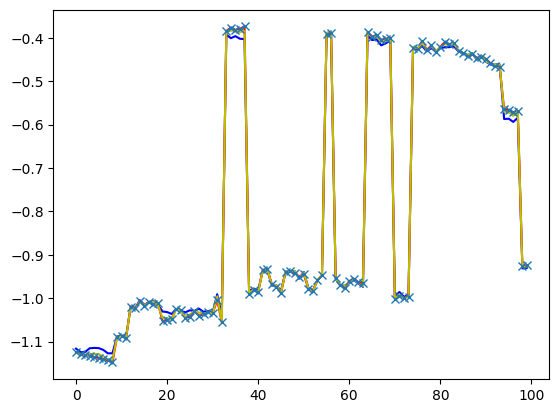

In [71]:
# training curves: comparison between y and y_pred
import matplotlib.pyplot as plt

plt.plot(y_pred_train_l2[:num], 'b')
plt.plot(y_pred_train_n[:num], 'r')
plt.plot(y_pred_train_gd[:num], 'y')

plt.plot(y_train[:num], 'x')

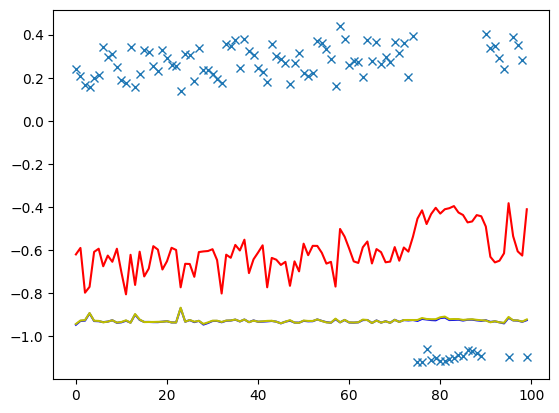

In [72]:
# val curves
import matplotlib.pyplot as plt

plt.plot(y_pred_val_l2[:num], 'b')
plt.plot(y_pred_val_n[:num], 'r')
plt.plot(y_pred_val_gd[:num], 'y')

plt.plot(y_val[:num], 'x')

# Task 3: Invented classification tasks

It is often easier to work with binary data than real-valued data: we don’t have to think so hard about how the values might be distributed, and how we might process them. We will invent some binary classification tasks, and fit these.

We will pick 20 positions within the range of training positions, and use each of these to define a classification task:

In [7]:
K = 20 # number of thresholded classification problems to fit
mx = np.max(y_train); mn = np.min(y_train); hh = (mx-mn)/(K+1)
thresholds = np.linspace(mn+hh, mx-hh, num=K, endpoint=True)
for kk in range(K):
    labels = y_train > thresholds[kk]
    # ... fit logistic regression to these labels

The logistic regression cost function and gradients are provided with the assignment in the function ```logreg_cost```. It is analogous to the ```linreg_cost``` function for least-squares regression, which is used by the ```fit_linreg_gradopt``` function that you used earlier.

Fit logistic regression to each of the 20 classification tasks above with $\alpha=30$
.

Given a feature vector, we can now obtain 20 different probabilities, the predictions of the 20 logistic regression models. Transform both the training and validation input matrices into new matrices with 20 columns, containing the probabilities from the 20 logistic regression models. You don’t need to loop over the rows of ```X_train``` or ```X_val```, you can use array-based operations to make the logistic regression predictions for every datapoint at once.

Fit a regularized linear regression model ($\alpha=30$) to your transformed 20-dimensional training set. Report the training and validation root mean square errors (RMSE) of this model.

In [8]:
def fit_logreg_gradopt(X, yy, alpha):
    """
    Fit a regularized logistic regression model using gradient optimization.
    """
    D = X.shape[1]
    args = (X, yy, alpha)
    init = (np.zeros(D), np.array(0))
    w_logreg, b_logreg = minimize_list(logreg_cost, init, args)
    return w_logreg, b_logreg

def logreg_k(X, yy, K, alpha=30):
    """
    Trains K binary logistic regression models on data using different threshold-based label splits.
    """
    mx = np.max(yy); mn = np.min(yy); hh = (mx-mn)/(K+1)
    thresholds = np.linspace(mn+hh, mx-hh, num=K, endpoint=True)
    
    # weights and biases for the K logistic regression models
    w_logreg_k = np.zeros((K, X_train.shape[1]))
    b_logreg_k = np.zeros((K))
    
    for kk in range(K):
        # get binary training labels based on thresholds[kk]
        labels = yy > thresholds[kk]
        
        w_logreg, b_logreg = fit_logreg_gradopt(X, labels, alpha)
        
        w_logreg_k[kk, :] = w_logreg
        b_logreg_k[kk] = b_logreg
    
    return w_logreg_k, b_logreg_k

def sigma(a):
    return 1 / (1 + np.exp(-a))

K = 20 # number of thresholded classification problems to fit

# Transform both the training and validation input matrices into new matrices with K columns
w_logreg_k, b_logreg_k = logreg_k(X_train, y_train, K)
X_train_new = sigma(X_train @ w_logreg_k.T + b_logreg_k)
X_val_new = sigma(X_val @ w_logreg_k.T + b_logreg_k)


w_linreg, b_linreg = fit_linreg_gradopt(X_train_new, y_train, alpha=30)

pred_train = X_train_new @ w_linreg + b_linreg
pred_val = X_val_new @ w_linreg + b_linreg

rmse_train_gd = rmse(y_train, pred_train)
rmse_val_gd = rmse(y_val, pred_val)

print('Training RMSE:', rmse_train_gd)
print('Validation RMSE:', rmse_val_gd)

Training RMSE: 0.1544116271864011
Validation RMSE: 0.25425057185503463


# Task 4: Small neural network

In Question 3 you fitted a small neural network. The logistic regression classifiers are sigmoidal hidden units, and a linear output unit predicts the outputs. However, you didn’t fit the parameters jointly to the obvious least squares cost function. A least squares cost function and gradients for this neural network are implemented in the nn_cost function provided.

Try fitting the neural network model to the training set, with a) a sensible random initialization of the parameters; b) the parameters initialized using the fits made in Q3.

Does one initialization strategy work better than the other? Does fitting the neural network jointly work better than the procedure in Q3? Your explanation should include any numbers that your answer is based on.


In [12]:
np.random.seed(42)

K = 20
D = X_train.shape[1]
alpha = 30


def fit_nn_gradopt(X, yy, alpha, init):
    """
    Fit a regularized logistic regression model using gradient optimization.
    """
    args = (X, yy, alpha)
    ww, bb, V, bk = minimize_list(nn_cost, init, args)
    return ww, bb, V, bk

# Glorot Initialization
def glorot_init(n_in, n_out):
    limit = np.sqrt(6 / (n_in + n_out))
    return np.random.uniform(-limit, limit, size=(n_out, n_in))

def init_nn_parameter_glorot_uniform(D, K):
    ww_init = glorot_init(K, 1).flatten()
    bb_init = np.array(0)
    V_init = glorot_init(D, K)
    bk_init = np.zeros(K)
    
    init = (ww_init, bb_init, V_init, bk_init)
    return init


# the parameters initialized using the fits made in Q3.
init = (w_linreg, b_linreg, w_logreg_k, b_logreg_k)
params_opt = fit_nn_gradopt(X_train, y_train, alpha, init)

F_train = nn_cost(params_opt, X_train)
F_val = nn_cost(params_opt, X_val)
rmse_train = rmse(F_train, y_train)
rmse_val = rmse(F_val, y_val)
print("Q3 Initialization:")
print('Training RMSE:', rmse_train)
print('Validation RMSE:', rmse_val)


# a sensible random initialization of the parameters: glorot uniform init.
init = init_nn_parameter_glorot_uniform(D, K)
params_opt_glorot = fit_nn_gradopt(X_train, y_train, alpha, init)

F_train = nn_cost(params_opt_glorot, X_train)
F_val = nn_cost(params_opt_glorot, X_val)
rmse_train_glorot = rmse(F_train, y_train)
rmse_val_glorot = rmse(F_val, y_val)
print("Glorot Initialization:")
print("Training RMSE:", rmse_train_glorot)
print("Validation RMSE:", rmse_val_glorot)

Q3 Initialization:
Training RMSE: 0.13983549082511781
Validation RMSE: 0.27480328069128135
Glorot Initialization:
Training RMSE: 0.13845562267123937
Validation RMSE: 0.26705014626550766


# Task 5: Bayesian optimisation

A popular application area of Gaussian processes is Bayesian optimisation, where the uncertainty in the probabilistic model is used to guide the optimisation of a function. Here we will use Bayesian optimisation with Gaussian processes for choosing the regularisation parameter $\alpha$. (We would normally use Bayesian optimisation when optimizing more than one parameter.)

Gaussian processes are used to represent our belief about an unknown function. In this case, the function we are interested in is the neural network’s validation log root mean square error (log RMSE) as a function of the regularisation paramter $\alpha$. In Bayesian optimisation, it is common to maximise the unknown function, so we will maximise the negative log RMSE.

We start with a Gaussian process prior over this function. As we observe the actual log RMSEs for particular $\alpha$’s we update our belief about the function by calculating the Gaussian process posterior.

Besides the Gaussian process framework that you’re already familiar with, Bayesian optimisation involves a so-called acquisition function. Given our Gaussian process posterior model, we use this function to decide which parameter to query next. The acquisition function describes how useful we think it will be to try a given $\alpha$, while considering the uncertainty that is represented in our posterior belief.

There are many popular acquisition functions in Bayesian optimisation. One example is the probability of improvement. Suppose we have observed $y^{(1)}$ to $y^{(N)}$ (here negative log RMSE at locations $\alpha^{(1)}$ to $\alpha^{(N)}$). Then the function takes the following form: $$
    \mathit{PI}(\alpha) = \Phi\left(\frac{\mu(\alpha) - \text{max}(y^{(1)},\dots,y^{N})}{\sigma(\alpha)}\right),$$ where $\mu(\alpha)$ is the Gaussian process posterior mean at location $\alpha$, $\sigma(\alpha)$ is the posterior standard deviation at location $\alpha$, and $\Phi$ denotes the cumulative density function of the Gaussian with mean 0 and variance 1.
    
We pick the next regularization constant $\alpha^{(N+1)}$ by maximizing the acquisition function: $$
    \alpha^{(N+1)} = {arg\,max}_{\alpha}\mathit{PI}(\alpha).$$
We then evaluate our model for this regularization parameter and update our posterior about the unknown function that maps $\alpha$ to negative log RMSE. We repeat the procedure multiple times and then pick the parameter that yielded the best performance $y$.

Write a function train_nn_reg that trains the neural network from Q4 for a given $\alpha$ parameter and returns the validation RMSE.

Consider $\alpha$ on the range ```np.arange(0, 50, 0.02)```. Pick three values from this set for $\alpha$ as training locations and use ```train_nn_reg``` on these locations. Use the remaining locations as values that you will consider with the acquisition function.

Take the performance of the neural network that you trained in Q4 a) as a baseline. Subtract your $\alpha$-observed log RMSEs from the log of this baseline and take the resulting values as $y^{(1)}$ to $y^{(3)}$. Then calculate the Gaussian process posterior for these observations. To do so, use ``gp_post_par`` from the support code. Use the default parameters for ``sigma_y``, ``ell`` and ``sigma_f``.

Implement the probability of improvement acquisition function. You can use scipy.stats.norm.cdf to calculate $\Phi$. With this acquisition function, iteratively pick new $\alpha$’s, re-train and evaluate each new model with ```train_nn_reg``` and update your posterior with ```gp_post_par```. Do five of these iterations.

Report the maximum probability of improvement together with its $\alpha$ for each of the five iterations. Also report the best $\alpha$ that this procedure found, and its validation and test RMSEs. Have we improved the model?

In this question, the function we are optimizing is the neural network’s validation log RMSE as a function of the regularisation parameter $\alpha$. Where is the observation noise coming from?

In [10]:
def train_nn_reg(alpha, X_train, y_train, X_val, y_val):
    K = 20
    D = X_train.shape[1]

    # Initialize parameters
    V_init_glorot = glorot_init(D, K)
    ww_init_glorot = glorot_init(K, 1).flatten()
    bk_init_glorot = np.zeros(K)
    bb_init_glorot = 0.0

    params_init_glorot = [ww_init_glorot, bb_init_glorot, V_init_glorot, bk_init_glorot]

    # Set optimization arguments
    args = (X_train, y_train, alpha)

    # Train the neural network
    params_opt_glorot = minimize_list(nn_cost, params_init_glorot, args)

    y_val_pred = nn_cost(params_opt_glorot, X_val)

    rmse_val_glorot = rmse(y_val, y_val_pred)

    return rmse_val_glorot

def acquisition_function_PI(mu, sigma, y_max):
    with np.errstate(divide='warn'):
        Z = (mu - y_max) / sigma
        PI_values = norm.cdf(Z)
    return PI_values

baseline_rmse = rmse(F_val, y_val) # Calculated in Q4
baseline_log_rmse = np.log(baseline_rmse)

# initial observation negative log RMSE
np.random.seed(42)
initial_alphas = np.random.choice(np.arange(0, 50, 0.2), size=3, replace=False)
initial_log_rmses = [np.log(train_nn_reg(alpha, X_train, y_train, X_val, y_val)) for alpha in initial_alphas]
initial_y = baseline_log_rmse - np.array(initial_log_rmses)

print("Initial alphas and observed log RMSE differences (y values):")
for alpha, y in zip(initial_alphas, initial_y):
    print(f"alpha = {alpha}, y = {y}")

remaining_alphas = np.setdiff1d(np.arange(0, 50, 0.2), initial_alphas)
rest_mu, rest_cov = gp_post_par(remaining_alphas, initial_alphas, initial_y)

best_alpha = None
best_rmse = float('inf')
observed_alphas = list(initial_alphas)
observed_ys = list(initial_y)

for iteration in range(5):
    # get std from posterior
    rest_std = np.sqrt(np.diag(rest_cov))

    y_max = max(observed_ys)

    PI_values = acquisition_function_PI(rest_mu, rest_std, y_max)

    # select alpha with max PI
    max_PI_index = np.argmax(PI_values)
    next_alpha = remaining_alphas[max_PI_index]
    max_PI = PI_values[max_PI_index]
    
    # train_nn_reg on next alpha
    next_rmse = train_nn_reg(next_alpha, X_train, y_train, X_val, y_val)
    next_log_rmse = np.log(next_rmse)
    next_y = baseline_log_rmse - next_log_rmse
    
    # update observed alphas and ys
    observed_alphas.append(next_alpha)
    observed_ys.append(next_y)
    
    # transform to numpy arrays
    observed_alphas_np = np.array(observed_alphas)
    observed_ys_np = np.array(observed_ys)
    
    # update GP posterior
    rest_mu, rest_cov = gp_post_par(remaining_alphas, observed_alphas_np, observed_ys_np)
    
    print(f"Iteration {iteration + 1}: max PI = {max_PI}, alpha = {next_alpha}, rmse = {next_rmse}")
    
    # update best alpha
    if next_rmse < best_rmse:
        best_rmse = next_rmse
        best_alpha = next_alpha

print("\nBest alpha found:", best_alpha)
print("Validation RMSE with best alpha:", best_rmse)

rmse_test = train_nn_reg(best_alpha, X_train, y_train, X_test, y_test)
print("Test RMSE with best alpha:", rmse_test)

Initial alphas and observed log RMSE differences (y values):
alpha = 28.400000000000002, y = 0.03277577103003004
alpha = 1.2000000000000002, y = 0.1053879297011282
alpha = 19.400000000000002, y = 0.018846732543706723


NameError: name 'norm' is not defined

# What next?
Try to improve regression performance beyond the methods we have tried so far. Explain what you tried, why you thought it might work better, how you evaluated your idea, and what you found.

Do not write more than 300 words for this part, not including your code (which you do need to include). The bulk of the marks available for this part are for motivating and trying something sensible, which can be simple, and evaluating it sensibly.



In [19]:
# Two layers
from scipy.stats import norm

def nn_cost_two_layers(params, X, yy=None, alpha=None):
    """
    Neural network cost function with two hidden layers.
    """
    W2, b2, W1, b1, V, bk = params

    # Forward pass
    A1 = np.dot(X, V.T) + bk[None, :]
    P1 = 1 / (1 + np.exp(-A1))

    # First hidden layer to second hidden layer
    A2 = np.dot(P1, W1.T) + b1[None, :]
    P2 = 1 / (1 + np.exp(-A2))

    # Second hidden layer to output
    F = np.dot(P2, W2) + b2  # (N,)
    
    if yy is None:
        return F

    # Compute residuals and loss
    res = F - yy
    E = np.dot(res, res) + alpha * (np.sum(V * V) + np.sum(W1 * W1) + np.sum(W2 * W2))

    # Backward pass
    F_bar = 2 * res
    W2_bar = np.dot(P2.T, F_bar) + 2 * alpha * W2
    b2_bar = np.sum(F_bar)

    P2_bar = np.dot(F_bar[:, None], W2[None, :])
    A2_bar = P2_bar * P2 * (1 - P2)
    W1_bar = np.dot(A2_bar.T, P1) + 2 * alpha * W1
    b1_bar = np.sum(A2_bar, axis=0)

    P1_bar = np.dot(A2_bar, W1)
    A1_bar = P1_bar * P1 * (1 - P1)
    V_bar = np.dot(A1_bar.T, X) + 2 * alpha * V
    bk_bar = np.sum(A1_bar, axis=0)

    return E, (W2_bar, b2_bar, W1_bar, b1_bar, V_bar, bk_bar)


In [ ]:
# Glorot Initialization
def glorot_init(n_in, n_out):
    limit = np.sqrt(6 / (n_in + n_out))
    return np.random.uniform(-limit, limit, size=(n_out, n_in))

def init_nn_parameters_two_layers(D, K1, K2):
    """
    Initialize parameters for a two-hidden-layer neural network.
    D: Input dimension.
    K1: Number of units in the first hidden layer.
    K2: Number of units in the second hidden layer.
    """
    V = glorot_init(D, K1)
    bk = np.zeros(K1)
    W1 = glorot_init(K1, K2)
    b1 = np.zeros(K2)
    W2 = glorot_init(K2, 1).flatten() 
    b2 = 0.0

    return [W2, b2, W1, b1, V, bk]

def train_nn_reg(alpha, X_train, y_train, X_val, y_val):
    D = X_train.shape[1]
    K1 = 20
    K2 = 10
    params_init = init_nn_parameters_two_layers(D, K1, K2)
    params_opt_glorot = minimize_list(nn_cost_two_layers, params_init, args=(X_train, y_train, alpha))

    y_val_pred = nn_cost_two_layers(params_opt_glorot, X_val)

    rmse_val_glorot = rmse(y_val, y_val_pred)

    return rmse_val_glorot

def acquisition_function_PI(mu, sigma, y_max):
    with np.errstate(divide='warn'):
        Z = (mu - y_max) / sigma
        PI_values = norm.cdf(Z)
    return PI_values

In [17]:
baseline_rmse = rmse(F_val, y_val) # Calculated in Q4
baseline_log_rmse = np.log(baseline_rmse)

# initial observation negative log RMSE
np.random.seed(42)
initial_alphas = np.random.choice(np.arange(0, 50, 0.2), size=3, replace=False)
initial_log_rmses = [np.log(train_nn_reg(alpha, X_train, y_train, X_val, y_val)) for alpha in initial_alphas]
initial_y = baseline_log_rmse - np.array(initial_log_rmses)

print("Initial alphas and observed log RMSE differences (y values):")
for alpha, y in zip(initial_alphas, initial_y):
    print(f"alpha = {alpha}, y = {y}")

remaining_alphas = np.setdiff1d(np.arange(0, 50, 0.2), initial_alphas)
rest_mu, rest_cov = gp_post_par(remaining_alphas, initial_alphas, initial_y)

best_alpha = None
best_rmse = float('inf')
observed_alphas = list(initial_alphas)
observed_ys = list(initial_y)

for iteration in range(5):
    # get std from posterior
    rest_std = np.sqrt(np.diag(rest_cov))

    y_max = max(observed_ys)

    PI_values = acquisition_function_PI(rest_mu, rest_std, y_max)

    # select alpha with max PI
    max_PI_index = np.argmax(PI_values)
    next_alpha = remaining_alphas[max_PI_index]
    max_PI = PI_values[max_PI_index]
    
    # train_nn_reg on next alpha
    next_rmse = train_nn_reg(next_alpha, X_train, y_train, X_val, y_val)
    next_log_rmse = np.log(next_rmse)
    next_y = baseline_log_rmse - next_log_rmse
    
    # update observed alphas and ys
    observed_alphas.append(next_alpha)
    observed_ys.append(next_y)
    
    # transform to numpy arrays
    observed_alphas_np = np.array(observed_alphas)
    observed_ys_np = np.array(observed_ys)
    
    # update GP posterior
    rest_mu, rest_cov = gp_post_par(remaining_alphas, observed_alphas_np, observed_ys_np)
    
    print(f"Iteration {iteration + 1}: max PI = {max_PI}, alpha = {next_alpha}, rmse = {next_rmse}")
    
    # update best alpha
    if next_rmse < best_rmse:
        best_rmse = next_rmse
        best_alpha = next_alpha

print("\nBest alpha found:", best_alpha)
print("Validation RMSE with best alpha:", best_rmse)

rmse_test = train_nn_reg(best_alpha, X_train, y_train, X_test, y_test)
print("Test RMSE with best alpha:", rmse_test)

Initial alphas and observed log RMSE differences (y values):
alpha = 28.400000000000002, y = -0.006406038788520307
alpha = 1.2000000000000002, y = 0.135990854772851
alpha = 19.400000000000002, y = 0.03992288274228861
Iteration 1: max PI = 0.271691650957655, alpha = 1.6, rmse = 0.2426506432441637
Iteration 2: max PI = 0.2080641174035316, alpha = 0.0, rmse = 0.26489204754618473
Iteration 3: max PI = 0.24296947738974378, alpha = 5.2, rmse = 0.24070624733652793
Iteration 4: max PI = 0.18729084654425687, alpha = 5.4, rmse = 0.22918908313792613
Iteration 5: max PI = 0.16429079408506558, alpha = 7.0, rmse = 0.23162292253987649

Best alpha found: 5.4
Validation RMSE with best alpha: 0.22918908313792613
Test RMSE with best alpha: 0.2750415925496988


In [20]:
# multi-parameters
from scipy.linalg import cho_factor, cho_solve

def gp_post_par(X_rest, X_obs, yy, sigma_y=0.05, ell=5.0, sigma_f=1.0):
    K_rest = gauss_kernel_fn(X_rest, X_rest, ell, sigma_f)
    K_rest_obs = gauss_kernel_fn(X_rest, X_obs, ell, sigma_f)
    K_obs = gauss_kernel_fn(X_obs, X_obs, ell, sigma_f)
    M = K_obs + sigma_y**2 * np.eye(len(yy))

    # Cholesky decomposition
    M_cho, M_low = cho_factor(M)

    # Posterior mean
    rest_cond_mu = np.dot(K_rest_obs, cho_solve((M_cho, M_low), yy))

    # Posterior covariance
    rest_cond_cov = K_rest - np.dot(K_rest_obs, cho_solve((M_cho, M_low), K_rest_obs.T))

    return rest_cond_mu, rest_cond_cov


def train_nn_reg(alpha, K1, K2, X_train, y_train, X_val, y_val):
    D = X_train.shape[1]
    params_init = init_nn_parameters_two_layers(D, K1, K2)
    params_opt_glorot = minimize_list(nn_cost_two_layers, params_init, args=(X_train, y_train, alpha))

    y_val_pred = nn_cost_two_layers(params_opt_glorot, X_val)

    rmse_val_glorot = rmse(y_val, y_val_pred)

    return rmse_val_glorot


In [22]:
# Initial observations: Randomly select 3 parameter combinations
np.random.seed(42)
D = X_train.shape[1]

initial_params = np.array([
    [10, 60, 10],  # (alpha, K1, K2)
    [15, 25, 15],
    [20, 30, 20]
])
initial_ys = np.array([
    train_nn_reg(alpha, K1, K2, X_train, y_train, X_val, y_val)
    for alpha, K1, K2 in initial_params
])

# Remaining parameter combinations to evaluate
param_grid = np.array([[a, k1, k2] for a in np.arange(0, 50, 5)
                                     for k1 in np.arange(50, 100, 5)
                                     for k2 in np.arange(5, 25, 5)])
remaining_params = np.array([p for p in param_grid if list(p) not in initial_params.tolist()])

# Initialize GP
observed_params = initial_params
observed_ys = initial_ys

for iteration in range(5):
    # GP posterior
    mu, cov = gp_post_par(remaining_params, observed_params, observed_ys)

    # Compute standard deviation
    sigma = np.sqrt(np.diag(cov))

    # Current best observed value
    y_max = np.max(observed_ys)

    # Acquisition function: Probability of Improvement (PI)
    PI_values = acquisition_function_PI(mu, sigma, y_max)

    # Select next parameters to evaluate (maximizing PI)
    next_index = np.argmax(PI_values)
    next_params = remaining_params[next_index]

    print(f"Iteration {iteration + 1}: Testing parameters {next_params}")

    # Evaluate model
    next_rmse = train_nn_reg(next_params[0], next_params[1], next_params[2],
                             X_train, y_train, X_val, y_val)

    # Update observations
    observed_params = np.vstack([observed_params, next_params])
    observed_ys = np.append(observed_ys, next_rmse)

    # Remove selected point from remaining parameters
    remaining_params = np.delete(remaining_params, next_index, axis=0)

# Best parameters
best_index = np.argmin(observed_ys)
best_params = observed_params[best_index]
print("\nBest parameters found:")
print(f"alpha = {best_params[0]}, K1 = {best_params[1]}, K2 = {best_params[2]}")
print("Validation RMSE:", observed_ys[best_index])

# Final test evaluation
rmse_test = train_nn_reg(best_params[0], best_params[1], best_params[2],
                         X_train, y_train, X_test, y_test)
print("Test RMSE with best parameters:", rmse_test)


Iteration 1: Testing parameters [10 55 10]
Iteration 2: Testing parameters [15 55 10]
Iteration 3: Testing parameters [15 60 10]
Iteration 4: Testing parameters [15 55 15]
Iteration 5: Testing parameters [15 60 15]

Best parameters found:
alpha = 15, K1 = 25, K2 = 15
Validation RMSE: 0.2515958101037228
Test RMSE with best parameters: 0.2842785473090928
